In [521]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib as mpl
import os
import array
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D

In [522]:
data = yf.download('AVAX-USD', start='2021-03-31', end='2022-03-31')

[*********************100%***********************]  1 of 1 completed


In [523]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-26,83.670631,86.689308,82.611275,85.955650,85.955650,666311785
2022-03-27,85.956848,89.824844,84.566086,89.824844,89.824844,759068100
2022-03-28,89.842903,96.075851,88.663391,89.604553,89.604553,1758254790
2022-03-29,89.523987,95.876266,89.514572,92.840889,92.840889,1642341694
2022-03-30,92.813957,100.078888,90.002953,95.779984,95.779984,1755845999


In [524]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-30,29.477430,30.783155,28.942513,29.625277,29.625277,221168524
2021-03-31,29.615747,29.886477,26.699457,28.728970,28.728970,221774579
2021-04-01,28.732580,29.296858,27.993950,28.418751,28.418751,172089242
2021-04-02,28.332315,29.574100,28.043386,29.117611,29.117611,167497181
2021-04-03,29.081627,32.780338,28.199560,28.251848,28.251848,424655897


In [525]:
ADJ =  data['Adj Close']

In [526]:
ADJ

Date
2021-03-30    29.625277
2021-03-31    28.728970
2021-04-01    28.418751
2021-04-02    29.117611
2021-04-03    28.251848
                ...    
2022-03-26    85.955650
2022-03-27    89.824844
2022-03-28    89.604553
2022-03-29    92.840889
2022-03-30    95.779984
Name: Adj Close, Length: 366, dtype: float64

<AxesSubplot:xlabel='Date'>

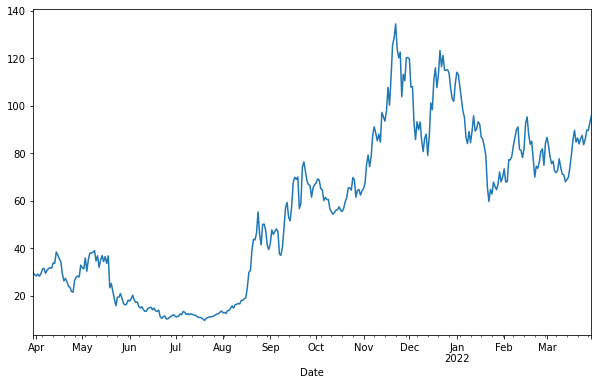

In [527]:
ADJ.plot(figsize=(10, 6))

In [528]:
ADJ.describe().round(2)

count    366.00
mean      56.24
std       33.43
min        9.65
25%       23.51
50%       59.64
75%       83.95
max      134.53
Name: Adj Close, dtype: float64

In [529]:
Logret = np.log(ADJ / ADJ.shift(1))
Logret.round(4)

Date
2021-03-30       NaN
2021-03-31   -0.0307
2021-04-01   -0.0109
2021-04-02    0.0243
2021-04-03   -0.0302
               ...  
2022-03-26    0.0271
2022-03-27    0.0440
2022-03-28   -0.0025
2022-03-29    0.0355
2022-03-30    0.0312
Name: Adj Close, Length: 366, dtype: float64

In [530]:
vol = np.sqrt(366) * Logret.std()
print('The annualised volatility is', round(vol*100,2), '%')

The annualised volatility is 149.07 %


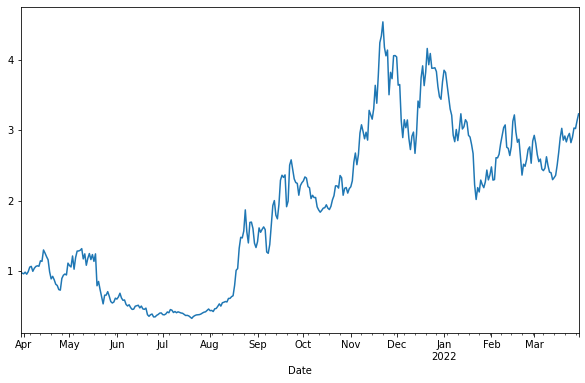

In [531]:
Logret.cumsum().apply(np.exp).plot(figsize=(10, 6));

In [532]:
# Binomial Tree (CRR) - Option Pricing
S0 = 95.77              # Spot price of Avalanche USD as on 31 March 2022
K = 110                 # Strike Price considered to be more than the current price as the stocks has been on the rise recently and had been as high as $134 in the recent past.
T = 0.02                # 1 week maturity annualized considering 365 trading days for crypto in a year.  
r = 0.016               # The annualised 12 months Treasury yield in US as per Bloomberg on April 3rd 2022
v = 1.4                 # Annualised Volatility as per the adjusted close price for a year.
N = 3                   # number of periods or number of time steps  
payoff = "put"          # payoff - either Call or Put

In [533]:
dT = float(T) / N                           # Delta t
u = np.exp(v * np.sqrt(dT))                 # up factor
d = 1.0 / u                                 # down factor

In [534]:
S = np.zeros((N + 1, N + 1))
S[0, 0] = S0
z = 1
for t in range(1, N + 1):
    for i in range(z):
        S[i, t] = S[i, t-1] * u
        S[i+1, t] = S[i, t-1] * d
    z += 1

In [535]:
S

array([[ 95.77      , 107.36765844, 120.36978259, 134.94645195],
       [  0.        ,  85.42509945,  95.77      , 107.36765844],
       [  0.        ,   0.        ,  76.19763617,  85.42509945],
       [  0.        ,   0.        ,   0.        ,  67.96690663]])

In [536]:
a = np.exp(r * dT)    # compounded return cal culation - risk free
p = (a - d)/ (u - d)  # probability of the price going up - risk neutral
q = 1.0 - p           # probability of the price going down - risk neutral
p

0.4719192764203129

In [537]:
q

0.5280807235796872

In [538]:
#finding crypto currency option value at each node of the Binomial Tree
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  2.63234156],
       [ 0.        ,  0.        ,  0.        , 24.57490055],
       [ 0.        ,  0.        ,  0.        , 42.03309337]])

In [539]:
#Once the above step is complete, the option value is then found for each node, starting at the penultimate time step, and working back to the first node of the tree (the valuation date) where the calculated result is the value of the option.
#European Option Calculation
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[16.8158415 ,  8.16346181,  1.38994057,  0.        ],
       [ 0.        , 24.55143638, 14.21826729,  2.63234156],
       [ 0.        ,  0.        , 33.79063112, 24.57490055],
       [ 0.        ,  0.        ,  0.        , 42.03309337]])

In [512]:
print('European put option value is', str( V[0,0]))

European put option value is 16.815841496443056


In [513]:
payoff = "call"

In [514]:
S_T = S[:,-1]
V = np.zeros((N + 1, N + 1))
if payoff =="call":
    V[:,-1] = np.maximum(S_T-K, 0.0)
elif payoff =="put":
    V[:,-1] = np.maximum(K-S_T, 0.0)
V

array([[ 0.        ,  0.        ,  0.        , 24.94645195],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [515]:
for j in range(N-1, -1, -1):
    for i in range(j+1):
        V[i,j] = np.exp(-r*dT) * (p * V[i,j + 1] + q * V[i + 1,j + 1])
V

array([[ 2.62103587,  5.55458441, 11.77145586, 24.94645195],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ]])

In [516]:
print('European call option value is', str( V[0,0]))

European call option value is 2.621035865043769


In [517]:
#finding European Option value calculated by using Monte Carlo Simulation
def mcs_simulation_np(p):
    M = p                  #steps
    I = p                  #simulations
    dt = T / M 
    S = np.zeros((M + 1, I))
    S[0] = S0 
    rn = np.random.standard_normal(S.shape) 
    for t in range(1, M + 1): 
        S[t] = S[t-1] * np.exp((r - v ** 2 / 2) * dt + v * np.sqrt(dt) * rn[t]) 
    return S

In [518]:
T = 0.02
r = 0.016
v = 1.4
S0 = 95.77
K = 110

In [540]:
S = mcs_simulation_np(1000)

In [541]:
S = np.transpose(S)
S

array([[ 95.77      ,  94.88848028,  94.86844156, ..., 145.22079685,
        146.81208231, 145.6807353 ],
       [ 95.77      ,  95.81745182,  95.90990338, ..., 100.60833765,
         99.94171913,  99.90855105],
       [ 95.77      ,  95.94903173,  94.5677495 , ...,  72.64426904,
         73.27419683,  73.87360902],
       ...,
       [ 95.77      ,  96.52989227,  96.32579309, ..., 125.43135167,
        127.39910085, 126.01948701],
       [ 95.77      ,  95.24586778,  94.93417761, ...,  68.60561628,
         68.69289295,  68.86078793],
       [ 95.77      ,  94.97930649,  95.52787038, ..., 106.61904275,
        105.35894355, 105.22275536]])

Text(0.5, 1.0, 'Frequency distribution of the simulated end-of-preiod values')

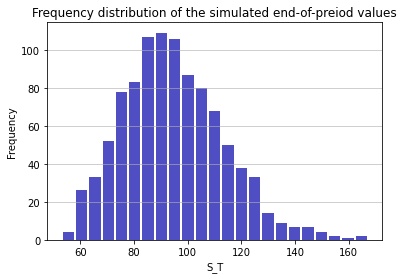

In [542]:
import matplotlib.pyplot as plt
n, bins, patches = plt.hist(x=S[:,-1], bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('S_T')
plt.ylabel('Frequency')
plt.title('Frequency distribution of the simulated end-of-preiod values')

In [543]:
p = np.mean(np.maximum(K - S[:,-1],0)) * np.exp(-r * T)
print('European put', str(p))

European put 17.82189260771073


In [544]:
c = np.mean(np.maximum(S[:,-1] - K,0)) * np.exp(-r * T)
print('European call', str(c))

European call 2.5432935060762536


In [545]:
#calculating European Option using BLACK SHOALES.
def euro_option_bs(S, K, T, r, v, payoff):
    
    #S: Avalanche USD Crypto currency spot price
    #K: strike price
    #T: time to maturity
    #r: risk free rate
    #v: volatility of underlying asset
    #payoff: call or put
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    if payoff == "call":
        option_value = S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        option_value = - S * si.norm.cdf(-d1, 0.0, 1.0) + K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return option_value

In [546]:
euro_option_bs(95.77, 110, 0.02, 0.016, 1.4, 'put')

17.09930668680596

In [547]:
S = np.linspace(75,120,20)
pp = np.zeros((len(S),1))
for i in range(len(S)):
    pp[i] = euro_option_bs(S[i], 110, 0.02, 0.016, 1.4, 'put')

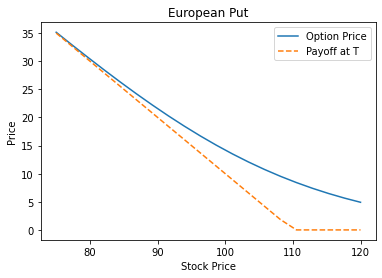

In [548]:
fig = plt.figure()
plt.plot(S, pp, '-')
plt.plot(S, np.maximum(110-S,0), '--')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('European Put')
plt.legend(['Option Price','Payoff at T'])

In [549]:
euro_option_bs(95.77, 110, 0.02, 0.016, 1.4, 'call')

2.9045010554066586

In [550]:
S = np.linspace(75,120,20)
cp = np.zeros((len(S),1))
for i in range(len(S)):
    cp[i] = euro_option_bs(S[i], 110, 0.02, 0.016, 1.4, 'call')

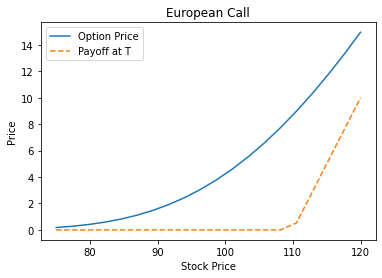

In [551]:
fig = plt.figure()
plt.plot(S, cp, '-')
plt.plot(S, np.maximum(S-110,0), '--')
plt.xlabel('Stock Price')
plt.ylabel('Price')
plt.title('European Call')
plt.legend(['Option Price','Payoff at T'])

In [552]:
def delta(S, K, T, r, v, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    if payoff == "call":
        delta = si.norm.cdf(d1, 0.0, 1.0)
    elif payoff == "put":
        delta =  -si.norm.cdf(-d1, 0.0, 1.0)
    
    return delta

In [553]:
delta(95.77, 110, 0.02, 0.016, 1.4, 'call')

0.27456129510637517

In [554]:
delta(95.77, 110, 0.02, 0.016, 1.4, 'put')

-0.7254387048936248

In [555]:
S = np.linspace(75,120,20)
Delta_Call = np.zeros((len(S),1))
Delta_Put = np.zeros((len(S),1))
for i in range(len(S)):
    Delta_Call [i] = delta(S[i], 110, 0.02, 0.016, 1.4, 'call')
    Delta_Put [i] = delta(S[i], 110, 0.02, 0.016, 1.4, 'put')

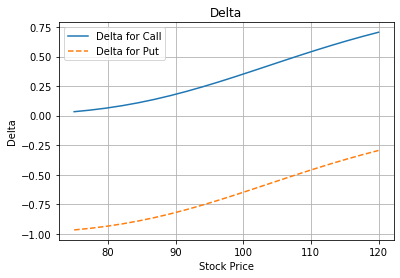

In [556]:
fig = plt.figure()
plt.plot(S, Delta_Call, '-')
plt.plot(S, Delta_Put, '--')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Delta')
plt.title('Delta')
plt.legend(['Delta for Call','Delta for Put'])

In [557]:
S = np.linspace(70, 120, 20)
T = np.linspace(0.002, 0.02, 30)
Delta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Delta[i,j] = delta(S[j], 110, T[i], 0.016, 1.4, 'put')

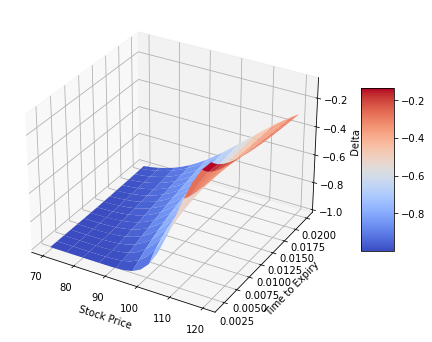

In [558]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Delta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Delta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [559]:
def gamma(S, K, T, r, v, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    gamma = si.norm.pdf(d1, 0.0, 1.0) / (v * S * np.sqrt(T))
    
    return gamma

In [560]:
gamma(95.77, 110, 0.02, 0.016, 1.4, 'call')

0.017583497978298727

In [561]:
gamma(95.77, 110, 0.02, 0.016, 1.4, 'put')

0.017583497978298727

In [562]:
S = np.linspace(75,120,20)
Gamma = np.zeros((len(S),1))
for i in range(len(S)):
    Gamma [i] = gamma(S[i], 110, 0.02, 0.016, 1.4, 'call')

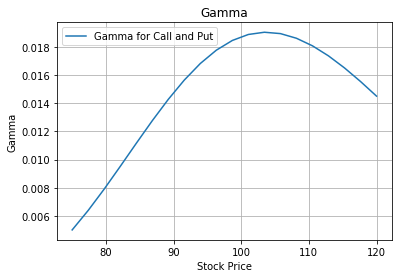

In [563]:
fig = plt.figure()
plt.plot(S, Gamma, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Gamma')
plt.title('Gamma')
plt.legend(['Gamma for Call and Put'])

In [564]:
S = np.linspace(70, 120, 21)
T = np.linspace(0.002, 0.02, 31)
Gamma = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Gamma[i,j] = gamma(S[j], 110, T[i], 0.016, 1.4, 'put')

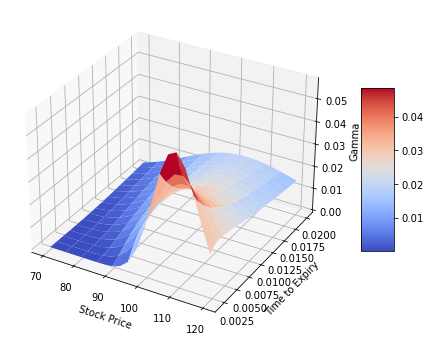

In [565]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Gamma, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Gamma')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [566]:
def speed(S, K, T, r, v, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    speed = - si.norm.pdf(d1, 0.0, 1.0) / ((vol **2) * (S**2) * np.sqrt(T)) * (d1 + v * np.sqrt(T))
    
    return speed

In [567]:
speed(95.77, 110, 0.02, 0.016, 1.4, 'call')

4.639103704312955e-05

In [568]:
speed(95.77, 110, 0.02, 0.016, 1.4, 'put')

4.639103704312955e-05

In [569]:
S = np.linspace(75,120,20)
Speed = np.zeros((len(S),1))
for i in range(len(S)):
    Speed [i] = speed(S[i], 110, 0.02, 0.016, 1.4, 'call')

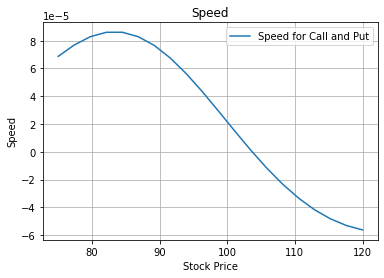

In [570]:
fig = plt.figure()
plt.plot(S, Speed, '-')
plt.grid()
plt.xlabel('Stock Price')
plt.ylabel('Speed')
plt.title('Speed')
plt.legend(['Speed for Call and Put'])

In [571]:
S = np.linspace(70, 120, 21)
T = np.linspace(0.002, 0.02, 31)
Speed = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Speed[i,j] = speed(S[j], 110, T[i], 0.016, 1.4, 'put')

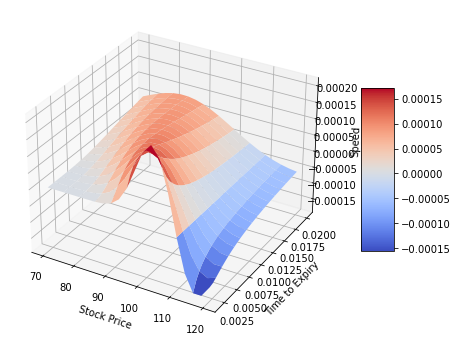

In [572]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Speed, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Speed')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [573]:
def theta(S, K, T, r, v, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    if payoff == "call":
        theta = v * S * si.norm.pdf(d1, 0.0, 1.0) / (2 * np.sqrt(T)) - S * si.norm.cdf(d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        theta = v * S * si.norm.pdf(-d1, 0.0, 1.0) / (2 * np.sqrt(T)) - S * si.norm.cdf(-d1, 0.0, 1.0) + r * K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return theta

In [574]:
theta(95.77, 110, 0.02, 0.016, 1.4, 'call')

132.12798957352928

In [575]:
theta(95.77, 110, 0.02, 0.016, 1.4, 'put')

89.95840943464498

In [576]:
T = np.linspace(0.003,0.02,30)
Theta_Call = np.zeros((len(T),1))
Theta_Put = np.zeros((len(T),1))
for i in range(len(T)):
    Theta_Call [i] = theta(95.77, 110, T[i], 0.016, 1.14, 'call')
    Theta_Put [i] = theta(95.77, 110, T[i], 0.016, 1.14, 'call')

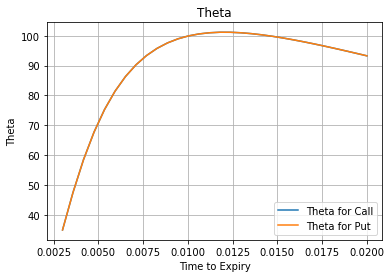

In [577]:
fig = plt.figure()
plt.plot(T, Theta_Call, '-')
plt.plot(T, Theta_Put, '-')
plt.grid()
plt.xlabel('Time to Expiry')
plt.ylabel('Theta')
plt.title('Theta')
plt.legend(['Theta for Call', 'Theta for Put'])

In [578]:
S = np.linspace(70, 120, 21)
T = np.linspace(0.002, 0.02, 31)
Theta = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Theta[i,j] = theta(S[j], 110, T[i], 0.016, 1.4, 'put')

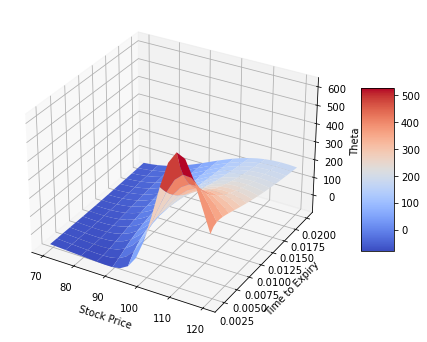

In [579]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Theta, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Theta')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [580]:
def rho(S, K, T, r, v, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    if payoff == "call":
        rho =  K * T * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0)
    elif payoff == "put":
        rho = - K * T * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0)
    
    return rho

In [581]:
rho(95.77, 110, 0.02, 0.016, 1.4, 'call')

0.46780468353861776

In [582]:
rho(95.77, 110, 0.02, 0.016, 1.4, 'put')

-1.7314914290893682

In [583]:
r = np.linspace(0.001,0.025,25)
Rho_Call = np.zeros((len(r),1))
Rho_Put = np.zeros((len(r),1))
for i in range(len(r)):
    Rho_Call [i] = rho(95.77, 110, 0.02, r[i], 1.4, 'call')
    Rho_Put [i] = rho(95.77, 110, 0.02, r[i], 1.4, 'put')

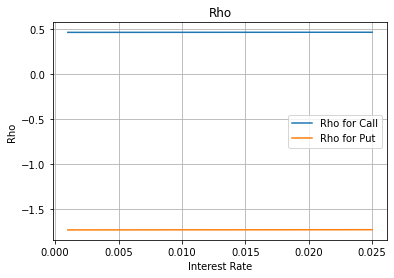

In [584]:
fig = plt.figure()
plt.plot(r, Rho_Call, '-')
plt.plot(r, Rho_Put, '-')
plt.grid()
plt.xlabel('Interest Rate')
plt.ylabel('Rho')
plt.title('Rho')
plt.legend(['Rho for Call', 'Rho for Put'])

In [585]:
S = np.linspace(70, 120, 21)
T = np.linspace(0.002, 0.02, 31)
Rho = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Rho[i,j] = rho(S[j], 110, T[i], 0.016, 1.4, 'put')

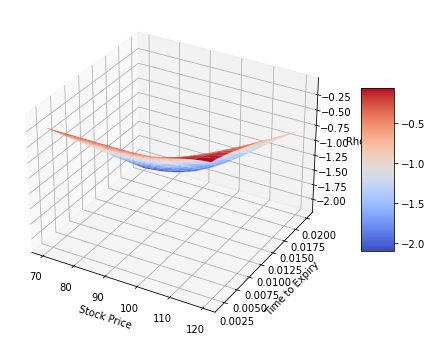

In [586]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Rho, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Rho')
fig.colorbar(surf, shrink=0.5, aspect=5);

In [587]:
def vega(S, K, T, r, v, payoff):
    
    d1 = (np.log(S / K) + (r + 0.5 * v ** 2) * T) / (v * np.sqrt(T))
    vega = S * np.sqrt(T) * si.norm.pdf(d1, 0.0, 1.0)
    
    return vega

In [588]:
vega(95.77, 110, 0.02, 0.016, 1.4, 'call')

4.515670887401027

In [589]:
vega(95.77, 110, 0.02, 0.016, 1.4, 'put')

4.515670887401027

In [590]:
vol = np.linspace(0.5,2.0,15)
Vega = np.zeros((len(vol),1))
for i in range(len(vol)):
    Vega [i] = vega(99.77, 95, 0.02, 0.016, vol[i], 'call')

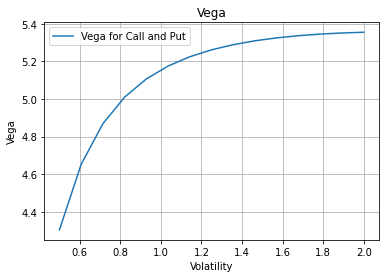

In [591]:
fig = plt.figure()
plt.plot(vol, Vega, '-')
plt.grid()
plt.xlabel('Volatility')
plt.ylabel('Vega')
plt.title('Vega')
plt.legend(['Vega for Call and Put'])

In [592]:
S = np.linspace(70, 120, 21)
T = np.linspace(0.002, 0.02, 31)
Vega = np.zeros((len(T),len(S)))
for j in range(len(S)):
    for i in range(len(T)):
        Vega[i,j] = vega(S[j], 110, T[i], 0.016, 1.4,'put')

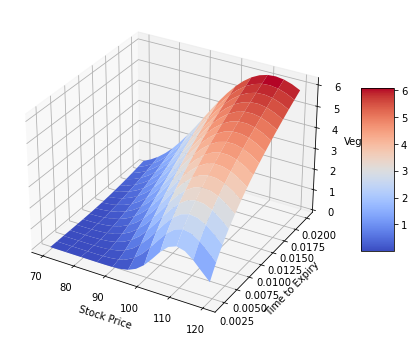

In [593]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection='3d')
S, T = np.meshgrid(S, T)
surf = ax.plot_surface(S, T, Vega, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
ax.set_xlabel('Stock Price')
ax.set_ylabel('Time to Expiry')
ax.set_zlabel('Vega')
fig.colorbar(surf, shrink=0.5, aspect=5);